In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Цель:
- понять, как принимаются решения о продуктовых изменениях;
- понять, что можно тестировать и какие границы применимости у A/Б-тестов;
- научиться проводить подготовку к A/Б-тестированию;
- научиться определять метрики для трактовки результатов тестирования.
# Задание:
Выберите топ-3 гипотез из предыдущего ДЗ.

Продумайте, какие А/Б тесты можно провести, чтобы проверить эти гипотезы.
Для каждого А/Б теста четко сформулируйте:
- тестируемое изменение
- бизнес-цель
- выбранную генеральную совокупность
- гипотезу (какие метрики должны измениться), укажите первичные и вторичные метрики
- метод агрегации значения метрики (поведение среднего юзера vs общее значение метрики)

Оформите результат в виде таблицы. Шаблон находится в грануле Тестовые датасеты и шаблонКак работать с файлом для выполнения домашнего задания #2

In [10]:
df = pd.read_csv('new_dataframe.csv')

# Дропаем лишюю коловнку, которая дублирует номера строк при импорте файла
df.drop(columns='Unnamed: 0', inplace=True)
df.head(5)

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


In [3]:
# Для численных столбцов
df.describe()

,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age
count,101500.000000,101500.000000,101500.0,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,91431.000000,101500.000000
mean,549874.802207,11.481429,1.0,0.900798,0.731389,0.620365,0.111025,0.571675,5.371152,25.906384
std,258600.104176,6.917522,0.0,0.298934,0.443239,0.485299,0.314164,0.494838,4.118531,7.838328
min,100093.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010946,18.000000
25%,328223.000000,5.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,2.438335,20.000000
50%,548827.000000,11.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,4.279565,24.000000
75%,773051.000000,17.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,7.129814,29.000000
max,999978.000000,23.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,40.268966,69.000000


In [12]:
# Для object-столбцов
df.describe(include='object')

,os,order_class,surge,rfm
count,101500,101500,91431,101500
unique,2,3,2,3
top,Android,economy,no surge,low
freq,56696,47219,59788,50436


In [4]:
print('Описание датафрейва')
print(df.info())
print('-'*10)
print('Пропуски в данных')
print(df.isnull().sum())

Описание датафрейва
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            101500 non-null  int64  
 1   hour               101500 non-null  int64  
 2   os                 101500 non-null  object 
 3   order_class        101500 non-null  object 
 4   surge              91431 non-null   object 
 5   app_opened         101500 non-null  int64  
 6   price_seen         101500 non-null  int64  
 7   order_made         101500 non-null  int64  
 8   ride_completed     101500 non-null  int64  
 9   user_cancelled     101500 non-null  int64  
 10  city_center_order  101500 non-null  int64  
 11  distance           91431 non-null   float64
 12  age                101500 non-null  int64  
 13  rfm                101500 non-null  object 
dtypes: float64(1), int64(9), object(4)
memory usage: 10.8+ MB
None
----------
Пропус

In [5]:
# 1. Анализ по операционной системе 
print('1. Анализ по операционной системе OS')
os_analysis = df.groupby('os').agg({
    'user_id': 'count', 
    'order_made': 'mean',
    'user_cancelled': 'mean',
    'ride_completed': 'mean',
    'price_seen': 'mean'
}).round(5)

os_analysis['Доля'] = (os_analysis['user_id'] / len(df) * 100).round(2)
print(os_analysis)

# Статистическая значимость разницы между операционными 
android_data = df[df['os'] == 'Android']['order_made']
ios_data = df[df['os'] == 'iOS']['order_made']

t_stat, p_value = stats.ttest_ind(android_data, ios_data, equal_var=False)
print('\nСтатистическая значимость разницы конверсии Android VS iOS:')
print(f'T-statistic: {t_stat:.5f}, p_value: {p_value:.5f}')
print('Разница стат. значима' if p_value < 0.05 else 'Разница не стат. значима')
print('-'*10)

# 2 Анализ по RFM-сегментам 
print('\n2. Анализ по RFM-сегментам')
rfm_analysis = df.groupby('rfm').agg({
    'user_id': 'count', 
    'order_made': 'mean',
    'user_cancelled': 'mean',
    'ride_completed': 'mean',
    'price_seen': 'mean'
}).round(5)
rfm_analysis['Доля'] = (rfm_analysis['user_id'] / len(df) * 100).round(2)
print(rfm_analysis)
print('-'*10)

# 3 Анализ по возрасту 
print('\n3. Анализ по возрасту')
df['age_group'] = pd.cut(df['age'],
                        bins=[18, 25, 35, 45, 70],
                        labels=['18-25', '26-35', '36-45', '46+'])

age_analysis = df.groupby('age_group', observed=False).agg({
    'user_id': 'count', 
    'order_made': 'mean',
    'user_cancelled': 'mean',
    'ride_completed': 'mean',
    'price_seen': 'mean'
}).round(5)
age_analysis['Доля'] = (age_analysis['user_id'] / len(df) * 100).round(2)
print(age_analysis)
print('-'*10)

# 4 Анализ по времени суток
print('\n4. Анализ по времени суток')
df['hour_group'] = pd.cut(df['hour'],
                        bins=[0, 6, 10, 17, 21, 24],
                        labels=['Ночь (0-6)', 'Утро (6-10)', 'День (10-17)', 'Вечер (17-21)', 'Поздний вечер (21-24)'])

hour_analysis = df.groupby('hour_group', observed=False).agg({
    'user_id': 'count', 
    'order_made': 'mean',
    'user_cancelled': 'mean',
    'ride_completed': 'mean',
}).round(5)
hour_analysis['Доля'] = (hour_analysis['user_id'] / len(df) * 100).round(2)
print(hour_analysis)
print('-'*10)

# 5 Анализ surge-ценообразования 
print('\n5. Анализ surge-ценообразования ')

if 'surge' in df.columns:
    surge_analysis = df.groupby('surge').agg({
        'user_id': 'count', 
        'order_made': 'mean',
        'user_cancelled': 'mean',
        'ride_completed': 'mean',
        }).round(5)
    hour_analysis['Доля'] = (hour_analysis['user_id'] / len(df) * 100).round(2)
    print(hour_analysis)
else: 
    print("Столбец 'surge' отсутствует")
print('-'*10)

# 6 Анализ по классам заказа 
print('\n6. Анализ по классам заказа ')

if 'order_class' in df.columns:
    surge_analysis = df.groupby('order_class').agg({
        'user_id': 'count', 
        'order_made': 'mean',
        'user_cancelled': 'mean',
        'ride_completed': 'mean',
        }).round(5)
    hour_analysis['Доля'] = (hour_analysis['user_id'] / len(df) * 100).round(2)
    print(hour_analysis)
else: 
    print("Столбец 'order_class' отсутствует")
print('-'*10)

1. Анализ по операционной системе OS
         user_id  order_made  user_cancelled  ride_completed  price_seen   Доля
os                                                                             
Android    56696     0.68437         0.12969         0.55468     0.88276  55.86
iOS        44804     0.79089         0.08740         0.70349     0.92362  44.14

Статистическая значимость разницы конверсии Android VS iOS:
T-statistic: -38.89209, p_value: 0.00000
Разница стат. значима
----------

2. Анализ по RFM-сегментам
        user_id  order_made  user_cancelled  ride_completed  price_seen   Доля
rfm                                                                           
high      47267     0.72765         0.10650         0.62115     0.89906  46.57
low       50436     0.73513         0.11611         0.61902     0.90291  49.69
medium     3797     0.72821         0.09982         0.62839     0.89439   3.74
----------

3. Анализ по возрасту
           user_id  order_made  user_cancelled  rid

✅ Хорошая активность: В среднем 4.19 сессии на пользователя, что свидетельствует о достаточно частом использовании приложения

✅ Молодая аудитория: Средний возраст 25.9 года - перспективная ЦА с высоким потенциалом лояльности

✅ Городское покрытие: 57.2% заказов из центра города - хорошее покрытие ключевых районов

**Обнадеживающие метрики:**

✅ Конверсия в заказ: 73.1% - хороший показатель, но есть пространство для улучшения

✅ Баланс платформ: Соотношение Android (55.9%) / iOS (44.1%) - типичное для рынка

# Высокий приоритет:
1. Исследовать причины отмен - почему 11.1% пользователей отменяют заказы?

2. Улучшить выполнение заказов - сократить разрыв 73.1% → 62.0%

3. Оптимизировать Android-экспериенс - учитывая доминирование платформы

# Средний приоритет:
1. Увеличить retention - работать с лояльностью активных пользователей

2. Расширить географию - увеличить покрытие за пределами центра города

# Мониторинг:
1. Отслеживать демографические изменения - динамика возраста и географии

2. Балансировать платформы - поддерживать паритет iOS/Android

In [7]:
def analyze_funnel(dataframe):
    funnel = {
        'Этап': ['Открыли приложение', 'Увидели цену', 'Сделали заказ', 'Завершили поездку'],
        'Количество': [
            dataframe['app_opened'].sum(),
            dataframe['price_seen'].sum(),
            dataframe['order_made'].sum(),
            dataframe['ride_completed'].sum()
        ]
    }

    funnel_df = pd.DataFrame(funnel)
    funnel_df['Конверсия от предыдущего'] = (funnel_df['Количество'] / funnel_df['Количество'].shift(1) * 100).round(2)
    funnel_df['Общая конверсия'] = (funnel_df['Количество'] / funnel_df['Количество'].iloc[0] * 100).round(2)
    funnel_df['Потери'] = (100 - funnel_df['Конверсия от предыдущего']).fillna(0)

    return funnel_df

funnel_df = analyze_funnel(df)
print("Воронка конверсии:")
print(funnel_df.to_string(index=False))

Воронка конверсии:
              Этап  Количество  Конверсия от предыдущего  Общая конверсия  Потери
Открыли приложение      101500                       NaN           100.00    0.00
      Увидели цену       91431                     90.08            90.08    9.92
     Сделали заказ       74236                     81.19            73.14   18.81
 Завершили поездку       62967                     84.82            62.04   15.18


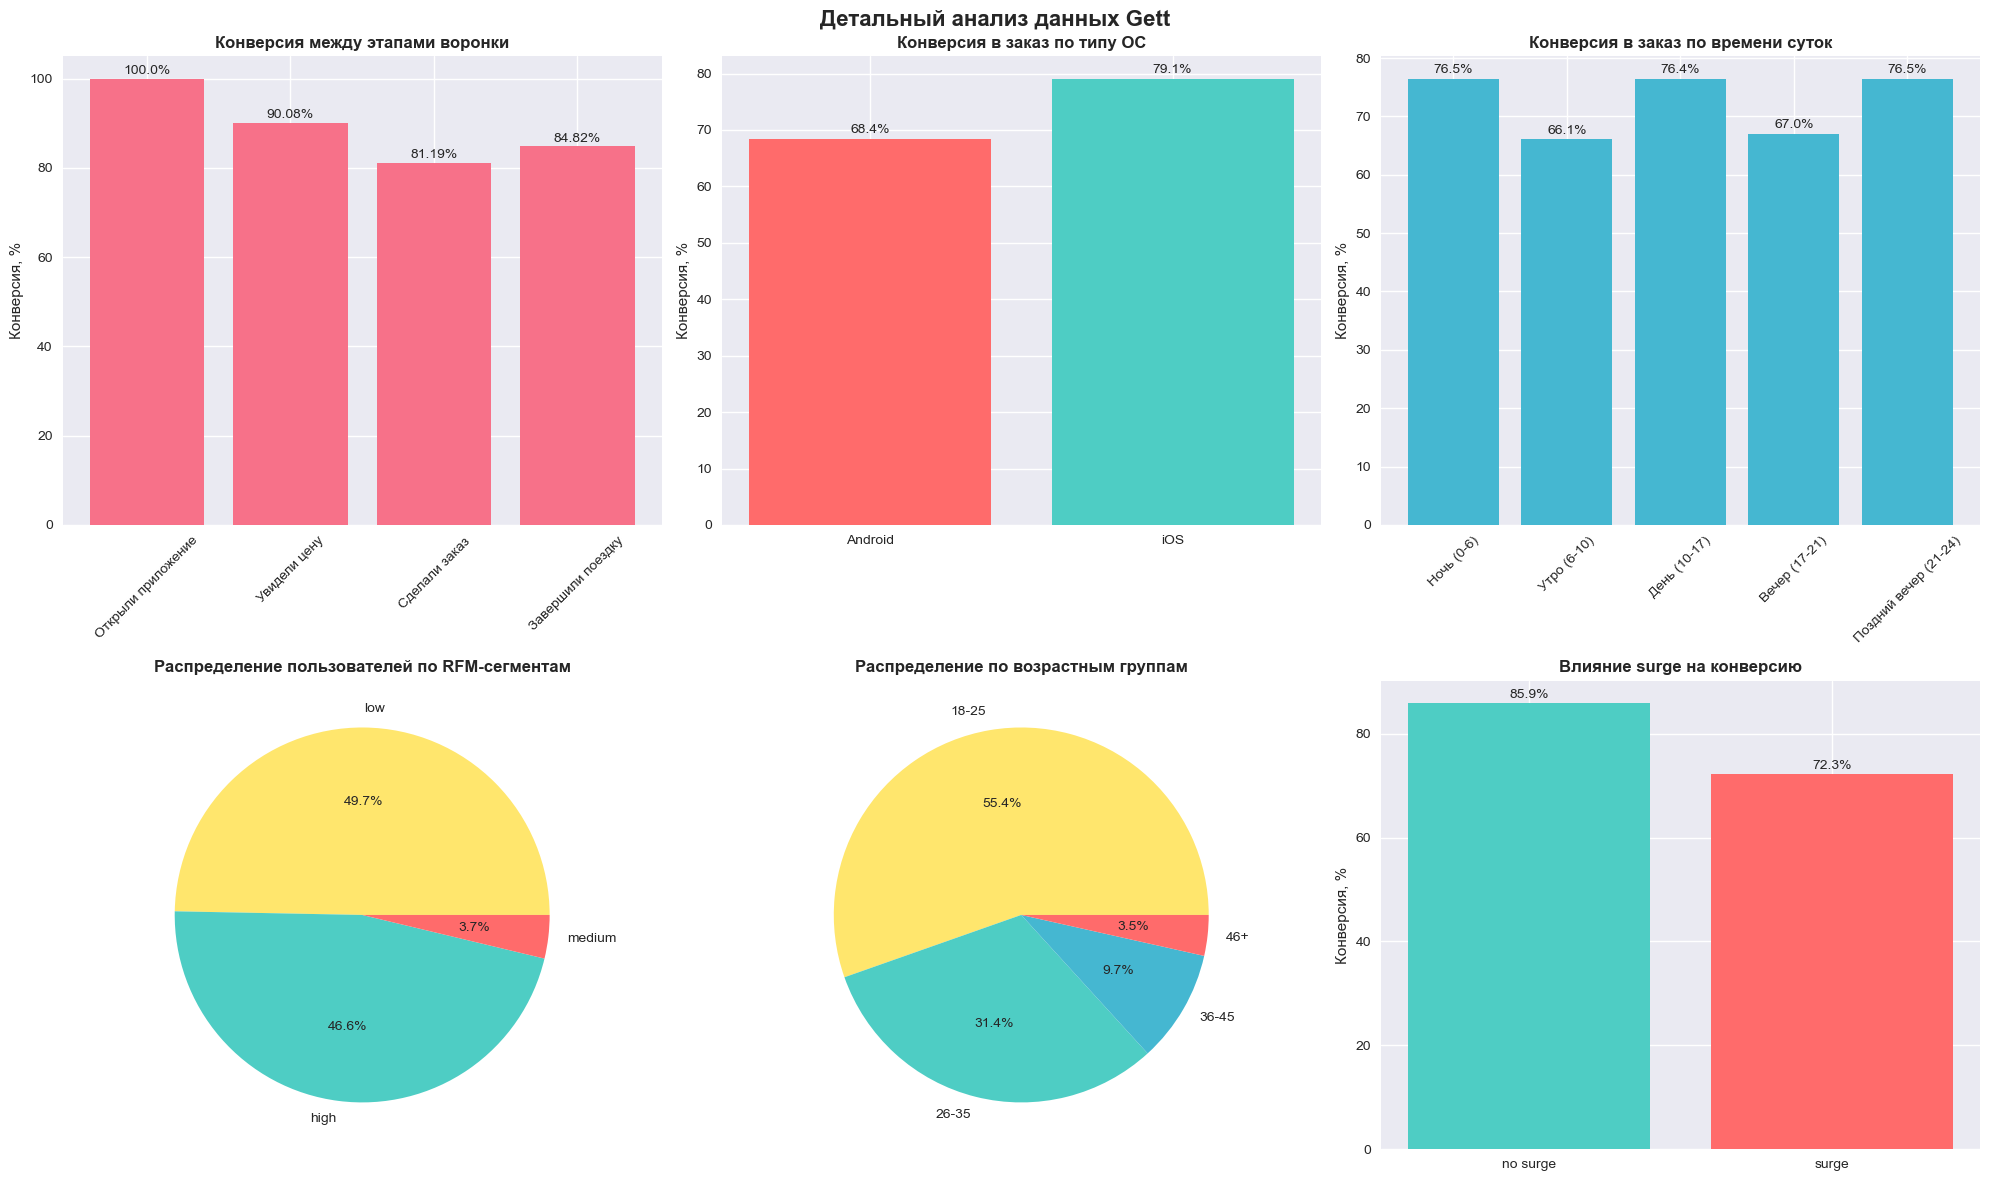

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Детальный анализ данных Gett', fontsize=16, fontweight='bold')

# 4.1 Воронка конверсии
axes[0,0].bar(funnel_df['Этап'], funnel_df['Конверсия от предыдущего'].fillna(100))
axes[0,0].set_title('Конверсия между этапами воронки', fontweight='bold')
axes[0,0].set_ylabel('Конверсия, %')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(funnel_df['Конверсия от предыдущего'].fillna(100)):
    axes[0,0].text(i, v + 1, f'{v}%', ha='center')

# 4.2 Конверсия по OS
os_conversion = df.groupby('os')['order_made'].mean()
axes[0,1].bar(os_conversion.index, os_conversion.values * 100, color=['#FF6B6B', '#4ECDC4'])
axes[0,1].set_title('Конверсия в заказ по типу ОС', fontweight='bold')
axes[0,1].set_ylabel('Конверсия, %')
for i, v in enumerate(os_conversion.values):
    axes[0,1].text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center')

# 4.3 Конверсия по времени
hour_conversion = df.groupby('hour_group', observed=False)['order_made'].mean()
axes[0,2].bar(hour_conversion.index.astype(str), hour_conversion.values * 100, color='#45B7D1')
axes[0,2].set_title('Конверсия в заказ по времени суток', fontweight='bold')
axes[0,2].set_ylabel('Конверсия, %')
axes[0,2].tick_params(axis='x', rotation=45)
for i, v in enumerate(hour_conversion.values):
    axes[0,2].text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center')

# 4.4 Распределение по RFM
rfm_distribution = df['rfm'].value_counts()
axes[1,0].pie(rfm_distribution.values, labels=rfm_distribution.index, autopct='%1.1f%%', colors=['#FFE66D', '#4ECDC4', '#FF6B6B'])
axes[1,0].set_title('Распределение пользователей по RFM-сегментам', fontweight='bold')

# 4.5 Распределение по возрасту
age_distribution = df['age_group'].value_counts()
axes[1,1].pie(age_distribution.values, labels=age_distribution.index, autopct='%1.1f%%', colors=['#FFE66D', '#4ECDC4', '#45B7D1', '#FF6B6B'])
axes[1,1].set_title('Распределение по возрастным группам', fontweight='bold')

# 4.6 Анализ surge (если есть)
if 'surge' in df.columns:
    surge_conversion = df.groupby('surge')['order_made'].mean()
    axes[1,2].bar(surge_conversion.index, surge_conversion.values * 100, color=['#4ECDC4', '#FF6B6B'])
    axes[1,2].set_title('Влияние surge на конверсию', fontweight='bold')
    axes[1,2].set_ylabel('Конверсия, %')
    for i, v in enumerate(surge_conversion.values):
        axes[1,2].text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center')
else:
    axes[1,2].text(0.5, 0.5, 'Данные по surge отсутствуют', ha='center', va='center', transform=axes[1,2].transAxes)

plt.tight_layout()
plt.savefig('gett_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


| №  | Тестируемое изменение                                                                                     | Бизнес-цель                                                                 | Генеральная совокупность                                                                                 | Гипотеза (метрики)                                                                                                                                                     | Метод агрегации                                                                 |
|----|-----------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| 1  | Добавление краткого объяснения причин отмены заказа на экране подтверждения отмены с возможностью указать причину | Снизить процент отмен заказов пользователями на 15%                         | Все пользователи, которые открывают приложение и видят цену, но ещё не подтвердили заказ                | **Первичная метрика:** `user_cancelled` (среднее значение) ↓<br>**Вторичные метрики:** `order_made` ↑, `ride_completed` ↑, `price_seen` (стабильность)                | Среднее значение на пользователя (user-level)                                  |
| 2  | Внедрение push-уведомления с напоминанием о завершении поездки через 5 минут после её начала              | Увеличить конверсию из заказа в завершенную поездку на 10%                  | Пользователи, которые сделали заказ (`order_made = 1`) и находятся в процессе поездки                    | **Первичная метрика:** `ride_completed` (среднее значение) ↑<br>**Вторичные метрики:** `user_cancelled` ↓, `order_made` (стабильность), `distance` (стабильность)   | Среднее значение на пользователя (user-level)                                  |
| 3  | Оптимизация экрана выбора класса поездки для пользователей Android: упрощенный интерфейс и быстрый выбор | Повысить конверсию в заказ для пользователей Android на 8%                  | Только пользователи Android, которые открыли приложение и видят цену (`price_seen = 1`)                   | **Первичная метрика:** `order_made` (среднее значение) ↑<br>**Вторичные метрики:** `user_cancelled` ↓, `ride_completed` ↑, `price_seen` (стабильность)               | Среднее значение на пользователя (user-level)                                  |
